In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
input_file = "cleaned_data.csv"

df = pd.read_csv(input_file)

# 1. How many rows and columns?

Number of features: 27
Number of entries: 80367
Number of houses ads: 46799
Number of apartments ads: 33569


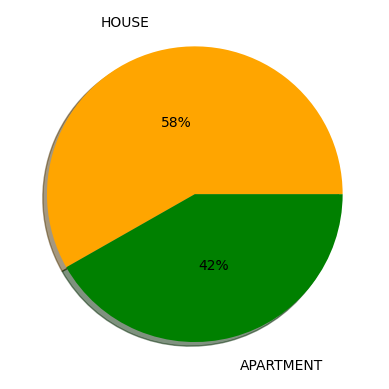

In [6]:
# Assuming your data is in a DataFrame called df
# Fix typos or similar categories
df['type'] = df['type'].replace({
    'HOUSE_GROUP': 'HOUSE',
    'APARTMENT_GROUP': 'APARTMENT'
})
# display(df['type'])
print(f'Number of features: {len(df.columns[3:])}')
print(f'Number of entries: {len(df)-1}')
df_house = df[df['type'] == 'HOUSE']
print(f'Number of houses ads: {len(df_house)}')
df_apartment = df[df['type'] == 'APARTMENT']
print(f"Number of apartments ads: {len(df_apartment)}")
# print(df_apartment)
plt.pie([len(df_house), len(df_apartment)], labels = ['HOUSE', 'APARTMENT'], startangle = 0, shadow = True, colors = ['orange', 'Green'],  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.show() 





/var/folders/dk/bqf1v96n63ld6wz2cs8m62w40000gn/T/ipykernel_73438/1726559002.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_house['price_per_sqm'], bins=50, kde=True, palette = 'Set1')


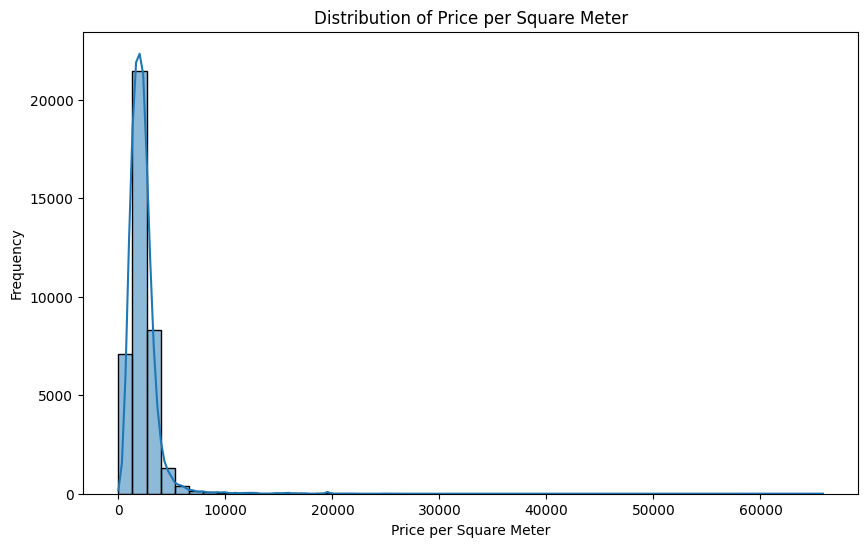

In [7]:
# df_house['price'] = df_house.to_num(df['price'], errors='coerce')
# df_house['habitableSurface'] = df_house.to_numeric(df['habitableSurface'], errors='coerce')
df_house = df_house.dropna(subset=['price', 'habitableSurface'])
df_house['price_per_sqm'] = df_house['price'] / df_house['habitableSurface']
plt.figure(figsize=(10,6))
sns.histplot(df_house['price_per_sqm'], bins=50, kde=True, palette = 'Set1')
plt.title('Distribution of Price per Square Meter')
plt.xlabel('Price per Square Meter')
plt.ylabel('Frequency')
plt.show()

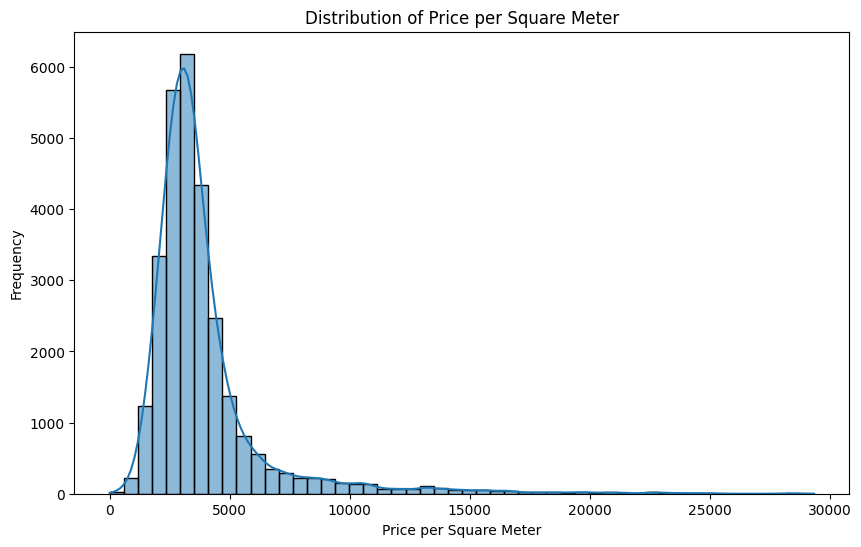

In [8]:

# Drop rows with missing price or area
df_apartment = df_apartment.dropna(subset=['price', 'habitableSurface'])
# Remove rows where price or habitableSurface is zero or less
df_apartment = df_apartment[(df_apartment['price'] > 0) & (df_apartment['habitableSurface'] > 0)]

df_apartment['price_per_sqm'] = df_apartment['price'] / df_apartment['habitableSurface']
# Filter out extreme outliers (e.g., over 30,000 €/m²)
df_apartment = df_apartment[df_apartment['price_per_sqm'] <= 30000]
plt.figure(figsize=(10,6))
sns.histplot(df_apartment['price_per_sqm'], bins=50, kde=True)
plt.title('Distribution of Price per Square Meter')
plt.xlabel('Price per Square Meter')
plt.ylabel('Frequency')
plt.show()

In [9]:
import pandas as pd
import folium
import requests

province_avg = df_apartment.groupby('province', as_index=False)['price_per_sqm'].mean()
geo_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/belgium_provinces.geojson"

response = requests.get(geo_url)

# Check for valid response
if response.status_code == 200:
    try:
        geo_data = response.json()
    except Exception as e:
        print("Error decoding JSON:", e)
else:
    print("Failed to fetch GeoJSON. Status code:", response.status_code)

# Create base map centered on Belgium
m = folium.Map(location=[50.85, 4.35], zoom_start=7)

# Add choropleth
folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=province_avg,
    columns=['province', 'price_per_sqm'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Price per m² (EUR)'
).add_to(m)

# Add layer control and save
folium.LayerControl().add_to(m)
m.save('belgium_price_per_sqm_map.html')



Failed to fetch GeoJSON. Status code: 404


NameError: name 'geo_data' is not defined

# 2. Correlation between variables and the price
Correlation ranges from -1 to 1:

- +1 = strong positive relationship (as feature increases, price increases)

- 0 = no linear relationship

- -1 = strong negative relationship

Only numeric features will be included. If you want to include categorical variables, they must first be encoded (e.g., one-hot or label encoding).

In [10]:
# HOUSE

features = ['bedroomCount', 'bathroomCount','hasLift', 'habitableSurface','hasBasement', 'facedeCount', 'floorCount', 'landSurface','livingRoomSurface','parkingCountIndoor','parkingCountOutdoor', 'toiletCount', 'kitchen_installed']
print(len(features))
cols_to_check = features + ['price']
df_house[cols_to_check] = df_house[cols_to_check].apply(pd.to_numeric, errors='coerce')
# Drop rows where any of these are missing
df_house_filtered = df_house.dropna(subset=cols_to_check)
correlations = df_house_filtered[cols_to_check].corr()['price'].drop('price')
# Sort correlation values in descending order
correlations_sorted = correlations.sort_values(ascending=False)

# Print sorted correlations
print(correlations_sorted)

13
toiletCount            0.586087
bathroomCount          0.568871
bedroomCount           0.391381
landSurface            0.323396
hasLift                0.287567
parkingCountIndoor     0.208010
livingRoomSurface      0.202556
facedeCount            0.157801
parkingCountOutdoor    0.154584
hasBasement            0.061678
habitableSurface       0.036815
kitchen_installed      0.017594
floorCount            -0.001412
Name: price, dtype: float64


/var/folders/dk/bqf1v96n63ld6wz2cs8m62w40000gn/T/ipykernel_73438/3426019130.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_sorted.index, y=correlations_sorted.values, palette=colors)


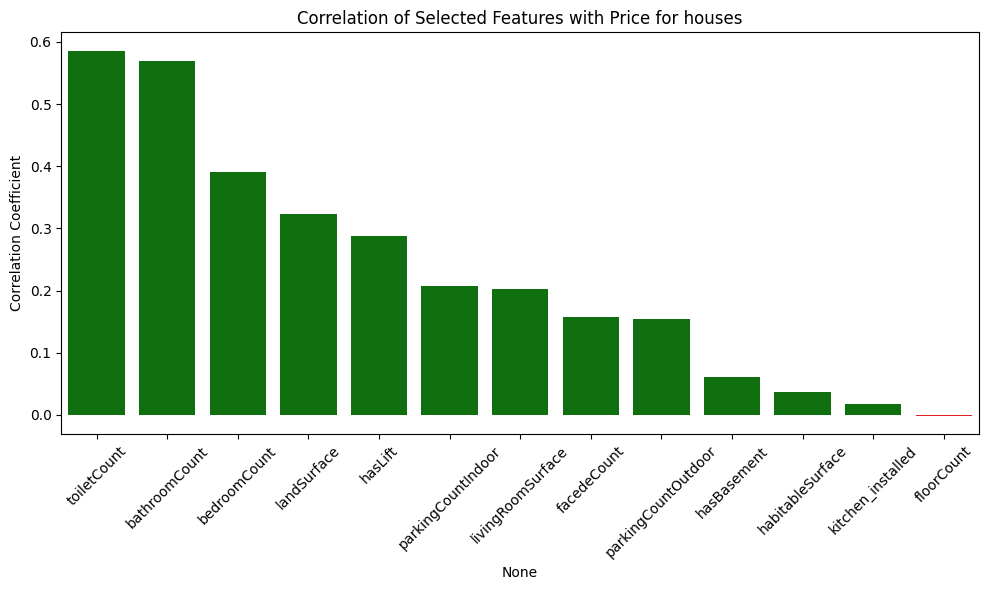

In [11]:
import numpy as np

# Step 1: Sort the correlation values
correlations_sorted = correlations.sort_values(ascending=False)

# Step 2: Define colors (e.g., blue for positive, red for negative)
colors = ['green' if val > 0 else 'red' for val in correlations_sorted.values]

# Step 3: Plot the sorted and color-coded bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_sorted.index, y=correlations_sorted.values, palette=colors)

# Step 4: Customize the plot
plt.title('Correlation of Selected Features with Price for houses')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [12]:
# APARTMENT

features = ['bedroomCount', 'bathroomCount','hasLift', 'habitableSurface','hasBasement', 'facedeCount', 'floorCount','livingRoomSurface','parkingCountIndoor','parkingCountOutdoor', 'toiletCount', 'kitchen_installed']
print(len(features))
cols_to_check = features + ['price']
df_apartment[cols_to_check] = df_apartment[cols_to_check].apply(pd.to_numeric, errors='coerce')
# Drop rows where any of these are missing
df_apartment = df_apartment.dropna(subset= features)
df_apartment = df_apartment.fillna(0) 
print(df_apartment[cols_to_check])
df_apartment_filtered = df_apartment.dropna(subset=cols_to_check)
correlations = df_apartment_filtered[cols_to_check].corr()['price'].drop('price')
# Sort correlation values in descending order
correlations_sorted = correlations.sort_values(ascending=False)

# Print sorted correlations
print(correlations_sorted)

12
       bedroomCount  bathroomCount  hasLift  habitableSurface  hasBasement  \
0               2.0            1.0     True             100.0         True   
2               2.0            1.0     True              87.0        False   
5               2.0            1.0     True              90.0         True   
10              2.0            1.0    False             120.0         True   
11              3.0            1.0     True             119.0         True   
...             ...            ...      ...               ...          ...   
80085           2.0            1.0     True              92.0        False   
80086           2.0            1.0     True              99.0        False   
80087           2.0            1.0     True              99.0        False   
80088           2.0            1.0     True             101.0        False   
80364           3.0            1.0     True              94.0         True   

       facedeCount  floorCount  livingRoomSurface  parkingCo

/var/folders/dk/bqf1v96n63ld6wz2cs8m62w40000gn/T/ipykernel_73438/2125368079.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_sorted.index, y=correlations_sorted.values, palette=colors)


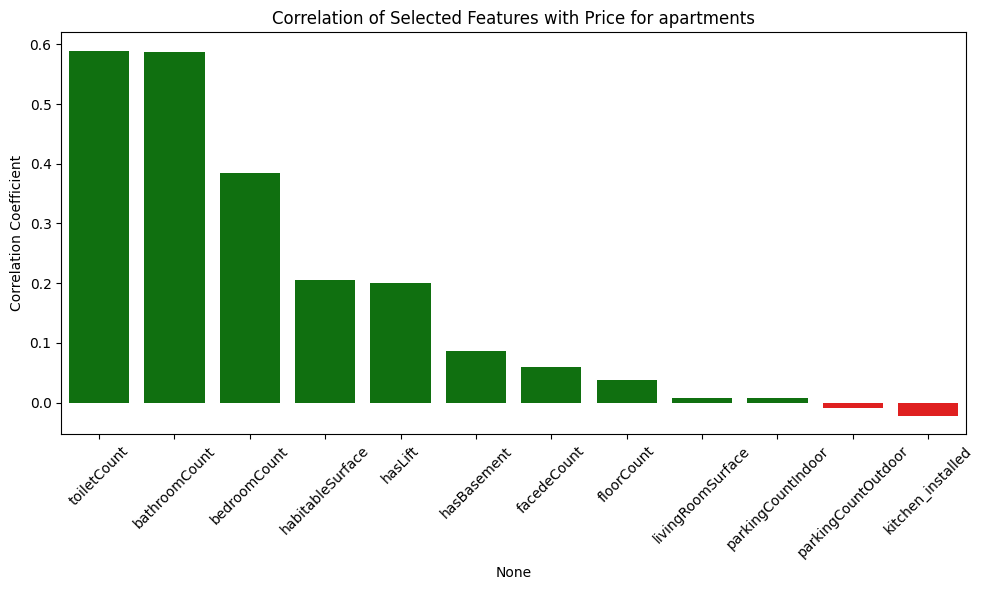

In [13]:
import numpy as np

# Step 1: Sort the correlation values
correlations_sorted = correlations.sort_values(ascending=False)

# Step 2: Define colors (e.g., blue for positive, red for negative)
colors = ['green' if val > 0 else 'red' for val in correlations_sorted.values]

# Step 3: Plot the sorted and color-coded bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_sorted.index, y=correlations_sorted.values, palette=colors)

# Step 4: Customize the plot
plt.title('Correlation of Selected Features with Price for apartments')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
# plt.figtext(0.5, 0.01, 'APARTMENTS', wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()
plt.show()


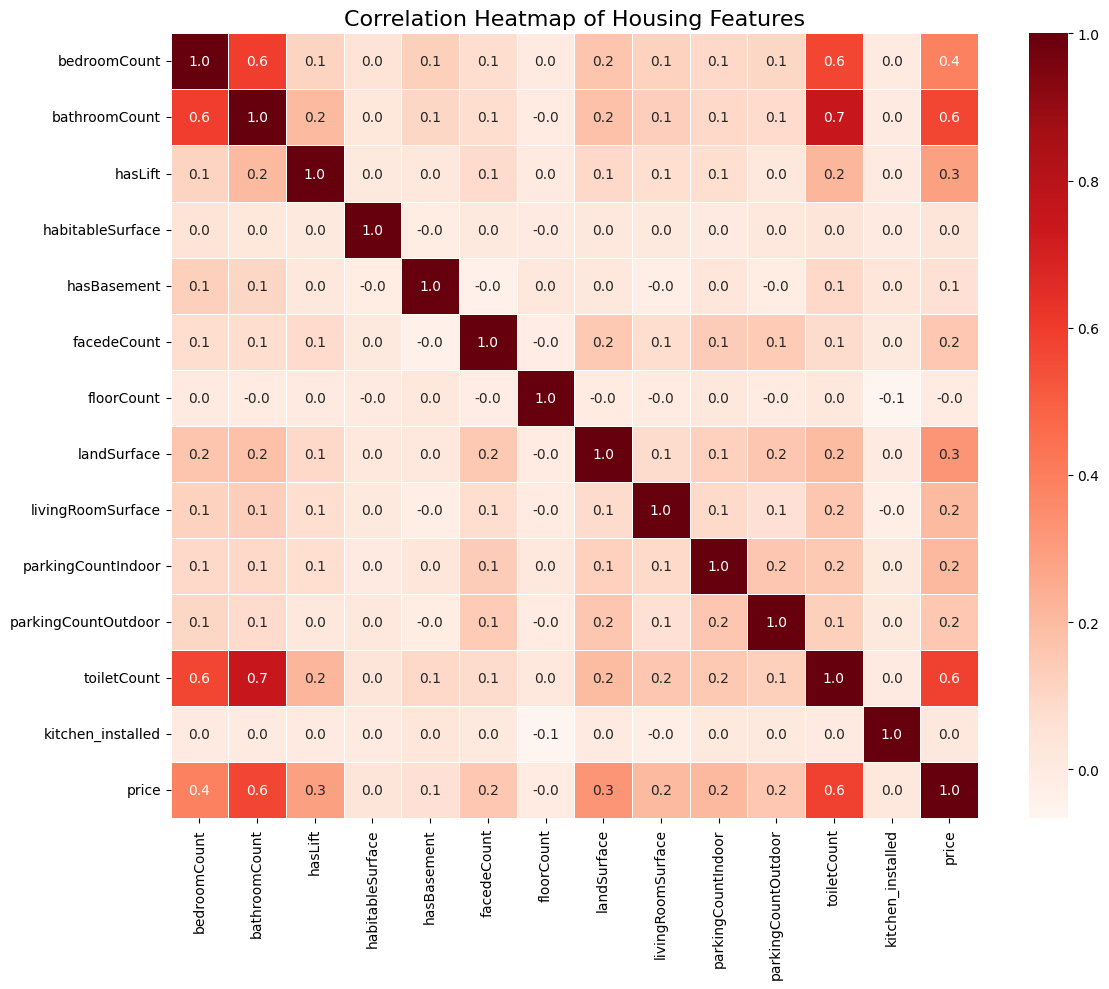

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select the features + price
features = [
    'bedroomCount', 'bathroomCount', 'hasLift', 'habitableSurface',
    'hasBasement', 'facedeCount', 'floorCount', 'landSurface',
    'livingRoomSurface', 'parkingCountIndoor', 'parkingCountOutdoor',
    'toiletCount', 'kitchen_installed'
]
cols_to_check = features + ['price']

# Convert columns to numeric, coercing errors
df_house[cols_to_check] = df_house[cols_to_check].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in selected columns
df_house_filtered = df_house.dropna(subset=cols_to_check)

# Compute the correlation matrix
corr_matrix = df_house_filtered[cols_to_check].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='Reds',       # Light red color palette
    fmt=".1f",
    linewidths=0.5,
)



plt.title('Correlation Heatmap of Housing Features', fontsize=16)
plt.tight_layout()
plt.show()

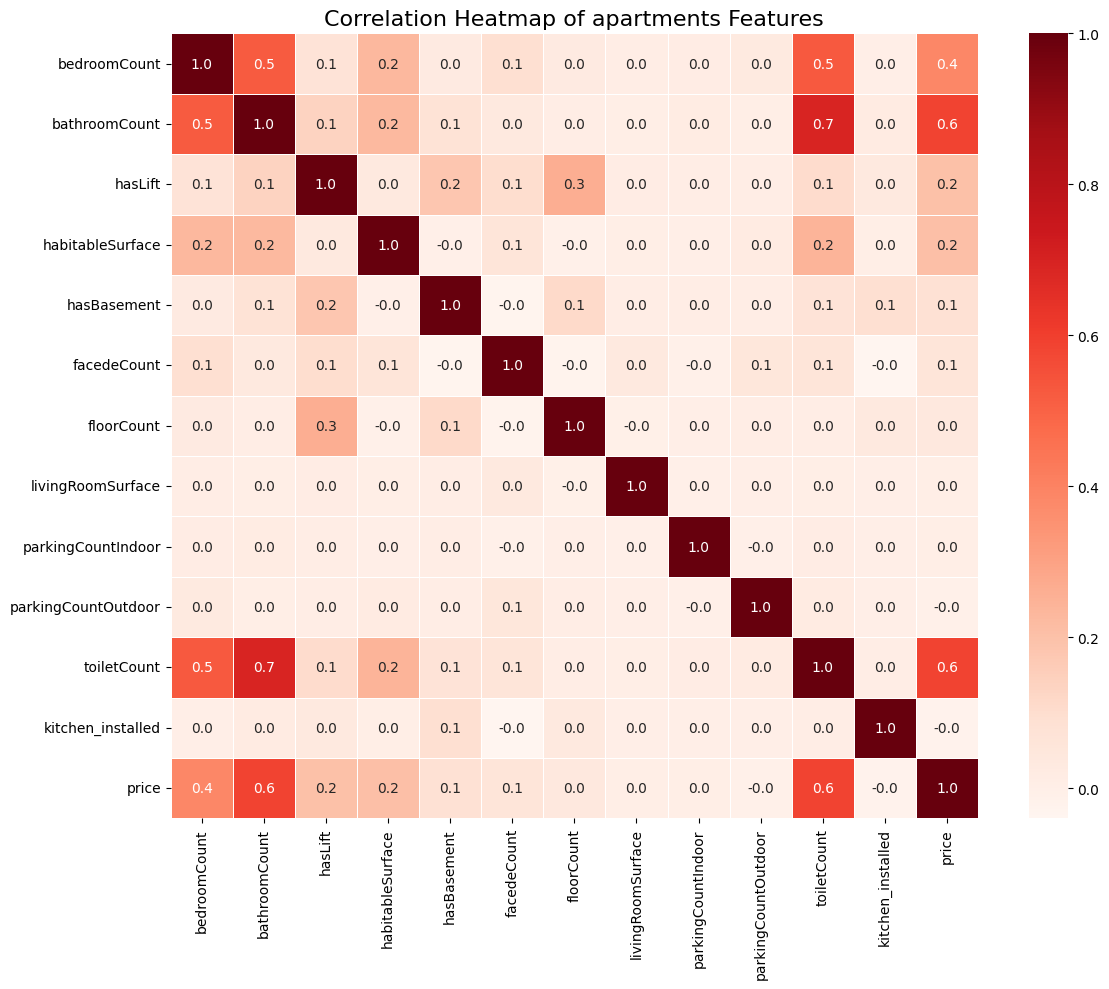

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select the features + price
features = [
    'bedroomCount', 'bathroomCount', 'hasLift', 'habitableSurface',
    'hasBasement', 'facedeCount', 'floorCount', 'livingRoomSurface', 
    'parkingCountIndoor', 'parkingCountOutdoor',
    'toiletCount', 'kitchen_installed'
]
cols_to_check = features + ['price']

# Convert columns to numeric, coercing errors
df_apartment[cols_to_check] = df_apartment[cols_to_check].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in selected columns
df_apartment = df_apartment.dropna(subset=cols_to_check)

# Compute the correlation matrix
corr_matrix = df_apartment_filtered[cols_to_check].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='Reds',       # Light red color palette
    fmt=".1f",
    linewidths=0.5,
)



plt.title('Correlation Heatmap of apartments Features', fontsize=16)
plt.tight_layout()
plt.show()

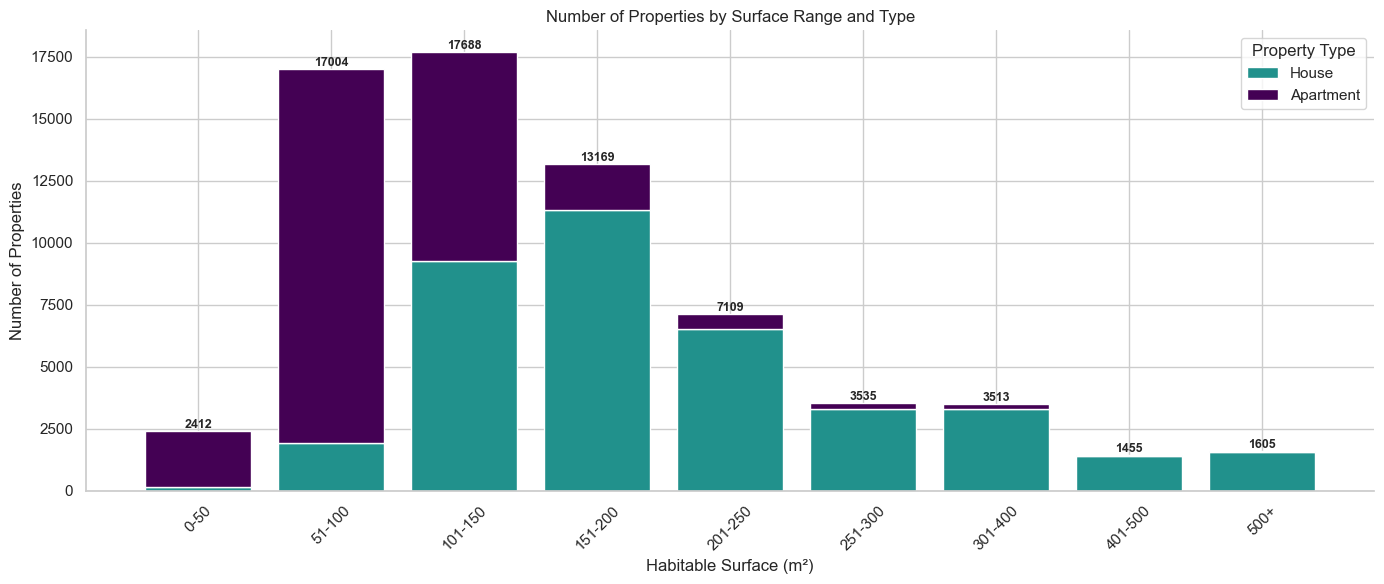

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

input_file = "cleaned_data.csv"
df = pd.read_csv(input_file)


sns.set_theme(style="whitegrid")

df['habitableSurface'] = pd.to_numeric(df['habitableSurface'], errors='coerce')


# Remove outliers
df = df[df['habitableSurface'] < 1000]  

# Define surface bins
surface_bins = [0, 50, 100, 150, 200, 250, 300, 400, 500, float('inf')]
surface_labels = [
    "0-50", "51-100", "101-150", "151-200", "201-250", "251-300",
    "301-400", "401-500", "500+"
]
df['surface_range'] = pd.cut(df['habitableSurface'], bins=surface_bins, labels=surface_labels, right=False)

# Cross-tab: surface range x type
pivot = pd.crosstab(df['surface_range'], df['type'])

# Order types for consistent coloring
type_order = ['HOUSE', 'APARTMENT']
pivot = pivot[type_order]

# Colors
type_colors = {
    'HOUSE': '#21918c',      # teal
    'APARTMENT': '#440154'   # purple
}

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bottom = [0] * len(pivot)
x = range(len(pivot))

for idx, col in enumerate(pivot.columns):
    ax.bar(x, pivot[col], bottom=bottom, label=col.title(), color=type_colors[col])
    bottom = [i + j for i, j in zip(bottom, pivot[col])]

# Add total counts on top
totals = pivot.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 1, str(total), ha='center', va='bottom', fontsize=9, fontweight='bold')

# Axis formatting
ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45)
ax.set_title("Number of Properties by Surface Range and Type")
ax.set_xlabel("Habitable Surface (m²)")
ax.set_ylabel("Number of Properties")
ax.legend(title="Property Type")

sns.despine()
plt.tight_layout()
plt.show()

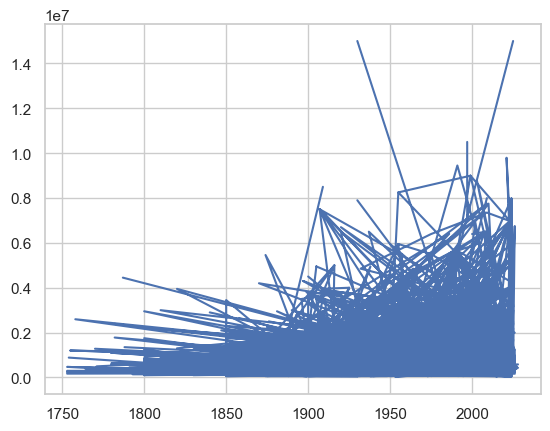

In [29]:
import matplotlib.pyplot as plt
import numpy as np

x = df_house['buildingConstructionYear']
y = df_house['price']
plt.plot(x, y)
plt.show()